# Testing Stock Fetcher 

## Imports 

In [1]:
# Reload Custom Modules 
import importlib
import src.beta_vae
import src.data_fetching 
import src.portfolio
import src.pca_enc
importlib.reload(src.beta_vae)
importlib.reload(src.data_fetching)
importlib.reload(src.portfolio)
importlib.reload(src.pca_enc)

<module 'src.pca_enc' from 'c:\\Users\\jairp\\OneDrive\\Desktop_remote\\HEC Montreal\\4. Fall 2024\\Deep Learning II\\Project\\StockDiversifier\\src\\pca_enc.py'>

In [ ]:
# General 
import os 
import json 
import random 
from tqdm.notebook import tqdm

# Data Science
import optuna 
import numpy as np 
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# PyTorch
import torch

# Custom Classes 
from src.beta_vae import Encoder
from src.beta_vae import Decoder
from src.beta_vae import BetaVAE
from src.pca_enc import PCAEncoder
from src.portfolio import Portfolio

# Custom Functions
from src.beta_vae import create_data_loaders
from src.beta_vae import create_single_data_loader
from src.beta_vae import objective
from src.beta_vae import train_beta_vae
from src.beta_vae import get_embeddings
from src.portfolio import fetch_and_calculate_returns
from src.portfolio import diversify_betavae_portfolio
from src.data_fetching import scrape_sp500_wikipedia
from src.data_fetching import fetch_stock_data
from src.data_fetching import prepare_data_for_vae

# Embeddings Extractors
from src.beta_vae import generate_embeddings_dict as get_vae_embeddings
from src.pca_enc import generate_embeddings_dict as get_pca_embeddings

In [3]:
custom_tickers = [
    'PLTR',  # Palantir Technologies Inc. (Technology)
    'COIN',  # Coinbase Global, Inc. (Financials)
    'WDAY',  # Workday, Inc. (Technology)
    'TTD',   # The Trade Desk, Inc. (Technology)
    'APO',   # Apollo Global Management, Inc. (Financials)
    'MELI',  # MercadoLibre, Inc. (Consumer Discretionary)
    'NVO',   # Novo Nordisk A/S (Healthcare)
    'ICON',  # Icon PLC (Healthcare)
    'TSM',   # Taiwan Semiconductor Manufacturing Company Limited (Technology)
    'SKX',   # Skechers U.S.A., Inc. (Consumer Discretionary)
    'BAYRY', # Bayer AG (Healthcare)
    'DISCK', # Discovery, Inc. (Communication Services)
    'FNV',   # Franco-Nevada Corporation (Materials)
    'SHOP',  # Shopify Inc. (Technology)
    'SQ',    # Square, Inc. (Technology)
    'UBER',  # Uber Technologies, Inc. (Industrials)
    'ZM',    # Zoom Video Communications, Inc. (Technology)
    'TWLO',  # Twilio Inc. (Technology)
    'MRNA',  # Moderna, Inc. (Healthcare)
    'WDAY',  # Workday, Inc. (Technology)
    'DOCU',  # DocuSign, Inc. (Technology)
    'VEEV',  # Veeva Systems Inc. (Healthcare)
    'LULU',  # Lululemon Athletica Inc. (Consumer Discretionary)
    'ROKU',  # Roku, Inc. (Communication Services)
    'CRWD',  # CrowdStrike Holdings, Inc. (Technology)
    'SNOW',  # Snowflake Inc. (Technology)
    'NET',   # Cloudflare, Inc. (Technology)
    'PINS',  # Pinterest, Inc. (Communication Services)
    'ETSY',  # Etsy, Inc. (Consumer Discretionary)
    'SPOT',   # Spotify Technology S.A. (Communication Services)
    "AAPL", # Apple Inc. (Technology)
]

## Fetching the data 

In [4]:
# Convert ndarray values to lists for JSON serialization
def serialize_ndarray(data_dict):
    return {key: (value.tolist() if isinstance(value, np.ndarray) else value) for key, value in data_dict.items()}

# Convert lists back to ndarrays if needed
def deserialize_ndarray(data_dict):
    return {key: (np.array(value) if isinstance(value, list) else value) for key, value in data_dict.items()}

In [5]:
# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

# extract the tickers from the dataframe
sp500_tickers = sp500_df["Symbol"].tolist()

# check for tikers with anomalies 
anomalies = [ticker for ticker in sp500_tickers if not ticker.isalnum()]
print(anomalies)

# check if apple is in the tickers
print("AAPL" in sp500_tickers)

# show the first couple of columns 
print(sp500_df.head())

['BRK.B', 'BF.B']
True
  Symbol             Security             GICS Sector
0    MMM                   3M             Industrials
1    AOS          A. O. Smith             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV               AbbVie             Health Care
4    ACN            Accenture  Information Technology


In [6]:
REFETCH = True 
LOAD_RETURNS = False 

############################################################################################
### Step 1: Scrape SP500

if REFETCH:
    # Scrape S&P 500 companies names, tikers and industris from Wikipedia
    sp500_df = scrape_sp500_wikipedia()  

    # Save the data to a csv file
    sp500_df.to_csv("data_raw/sp500_df.csv", index=False)
else:
    sp500_df = pd.read_csv("data_raw/sp500_df.csv")

############################################################################################
### Step 1: Scrape SP500
############################################################################################
## Step 2: Fetch Stock Data Features

if REFETCH:
    # Fetch data for all sp500 + custom tickers
    stock_data, sector_mapping, industry_mapping = fetch_stock_data(sp500_df, custom_tickers, 
                                                                    period = "1y", interval = "1wk",
                                                                    savepath="data_raw/stock_data.csv") # Fetch data
else: 
    # read data from file
    stock_data = pd.read_csv("data_raw/stock_data.csv", index_col=0).reset_index()

Fetching stock data...:  24%|██▍       | 127/527 [03:16<10:08,  1.52s/it]ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetching stock data...:  31%|███       | 164/527 [04:18<08:46,  1.45s/it]AMTM: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
AMTM: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
Fetching stock data...:  31%|███▏      | 165/527 [04:18<06:27,  1.07s/it]$DISCK: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$DISCK: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
Fetching stock data...:  40%|████      | 212/527 [05:27<07:29,  1.43s/it]SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid,

Completed fetching stock data in 834.63 seconds.
saving data to data_raw/stock_data.csv


In [7]:
############################################################################################
## Step 3: Fetch Returns for all tickers

if LOAD_RETURNS:
    # Load the returns from the file
    with open("data_raw/all_returns.json", "r") as f:
        all_returns = json.load(f)

    # Deserialize loaded data
    all_returns = deserialize_ndarray(all_returns)

    # Show the first few tickers and their returns
    print("First few tickers and their returns:")
    for ticker, returns in list(all_returns.items())[:5]:
        print(f"{ticker}: {returns[:5]}...")  # Print first 5 returns for each ticker

else: 
    # Fetch and calculate returns for the all tickers in the S&P 500 and additional tickers
    all_tickers = stock_data["Ticker"].values.tolist()  # All S&P 500 tickers
    print(f"number of tickers: {len(all_tickers)}")

    # Fetch and calculate returns for all tickers
    all_returns = fetch_and_calculate_returns(all_tickers, period="1y", interval="1wk", price_column="Close")

    # Find the mode of the lengths of the returns among all tickers
    return_lengths = [len(returns) for returns in all_returns.values()]
    return_length_mode = max(set(return_lengths), key=return_lengths.count)
    
    # Ensure to keep only the returns with the mode length and report the discarded tickers 
    discarded_tickers = [ticker for ticker, returns in all_returns.items() if len(returns) != return_length_mode]
    all_returns = {ticker: returns for ticker, returns in all_returns.items() if len(returns) == return_length_mode}
    print(f"Discarded tickers with inconsistent return lengths: {discarded_tickers}")

    # Remove from stock_data the tickers with inconsistent return lengths
    stock_data = stock_data[stock_data["Ticker"].isin(all_returns.keys())].reset_index().drop(columns=["index"])

    print("Total number of tickers with consistent return lengths:", len(all_returns))
    print("stock_date shape:", stock_data.shape)

    # Save the dictionary with the returns to a file using json 
    with open("data_raw/all_returns.json", "w") as f:
        print(f"Saving returns to {f.name}")
        json.dump(serialize_ndarray(all_returns), f, indent=4)

############################################################################################
## Step 4: Prepare Data for VAE	

# Prepare data for VAE
stock_data_vae = prepare_data_for_vae(stock_data) 

number of tickers: 520


Fetching Data:  88%|████████▊ | 459/520 [08:57<03:51,  3.80s/ticker]

No data found for ticker: PSX


Fetching Data: 100%|██████████| 520/520 [10:08<00:00,  1.17s/ticker]

Discarded tickers with inconsistent return lengths: ['GEV', 'SOLV']
Total number of tickers with consistent return lengths: 517
stock_date shape: (517, 18)
Saving returns to data_raw/all_returns.json


In [8]:
# Show one example return series
print("Returns for AAPL:")
print(all_returns["AAPL"])

Returns for AAPL:
[ 0.00950388 -0.02009418 -0.00552689 -0.05895183  0.02616181  0.03033562
  0.00448944 -0.03414403  0.01614209 -0.03339895  0.00115197 -0.01566941
 -0.04970521  0.01107025 -0.00196965 -0.00464362 -0.01108006  0.04110163
 -0.06542058  0.02606062  0.08316588 -0.00179947  0.03866449  0.00057929
  0.01194867  0.02413527  0.07923203 -0.02353049  0.01508496  0.0746368
  0.01855617 -0.02702351 -0.02830899  0.00871714 -0.01646491  0.04536618
  0.00465631  0.00952219 -0.0357205   0.00760797  0.02561793 -0.00179665
 -0.00434609  0.00330688  0.03274001 -0.01527655 -0.03673136  0.01816883
 -0.00754524  0.02164442  0.03245316  0.02405929]


In [9]:
stock_data.head()

,Ticker,Company Name,Market Cap,Sector,Industry,Open Price,Close Price,High Price,Low Price,Last Close,52 Week High,52 Week Low,Last Month Volatility,52 Week Volatility,Yearly Dividend Rate,Last Year Return Rate,Sector_encoded,Industry_encoded
0,F,Ford Motor Company,4.149159e+10,Consumer Discretionary,Auto Manufacturers,11.354958,11.343293,14.426230,9.219187,10.440000,14.426232,9.219188,0.368698,0.368682,0.60,0.044967,0,0
1,PLD,"Prologis, Inc.",1.053894e+11,Real Estate,REIT - Industrial,119.996288,120.023702,133.491226,99.505196,113.790001,133.601176,99.505194,0.261086,0.250361,3.84,-0.015337,1,1
2,FOXA,Fox Corporation,2.076555e+10,Communication Services,Entertainment,35.141518,35.370908,47.584999,27.847296,46.650002,47.584999,27.960515,0.187664,0.207548,0.54,0.622158,2,2
3,UNP,Union Pacific Corporation,1.422461e+11,Industrials,Railroads,238.713770,238.597010,258.070007,217.393391,234.630005,258.070007,217.393391,0.182160,0.191305,5.36,0.029255,3,3
4,PNR,Pentair plc,1.785486e+10,Industrials,Specialty Industrial Machinery,83.089755,83.783449,110.709999,64.568911,108.059998,110.709999,65.013804,0.242270,0.251658,0.92,0.645097,3,4


In [10]:
# Display the data 
print(stock_data_vae.head())

     Market Cap  Open Price  Close Price  High Price   Low Price  Last Close  \
0  4.149159e+10   11.354958    11.343293   14.426230    9.219187   10.440000   
1  1.053894e+11  119.996288   120.023702  133.491226   99.505196  113.790001   
2  2.076555e+10   35.141518    35.370908   47.584999   27.847296   46.650002   
3  1.422461e+11  238.713770   238.597010  258.070007  217.393391  234.630005   
4  1.785486e+10   83.089755    83.783449  110.709999   64.568911  108.059998   

   52 Week High  52 Week Low  Last Month Volatility  52 Week Volatility  ...  \
0     14.426232     9.219188               0.368698            0.368682  ...   
1    133.601176    99.505194               0.261086            0.250361  ...   
2     47.584999    27.960515               0.187664            0.207548  ...   
3    258.070007   217.393391               0.182160            0.191305  ...   
4    110.709999    65.013804               0.242270            0.251658  ...   

   Industry_Tools & Accessories  Indus

In [11]:
# Print number of columns for stock_data 
print(len(stock_data.columns))

# Print number of columns in total 
print(len(stock_data_vae.columns))

# Print total number of rows 
print(len(stock_data_vae))

# Print the data types of the columns
print(stock_data_vae.dtypes)

18
145
517
Market Cap                                 float64
Open Price                                 float64
Close Price                                float64
High Price                                 float64
Low Price                                  float64
                                            ...   
Industry_Utilities - Regulated Electric    float64
Industry_Utilities - Regulated Gas         float64
Industry_Utilities - Regulated Water       float64
Industry_Utilities - Renewable             float64
Industry_Waste Management                  float64
Length: 145, dtype: object


In [12]:
print(stock_data_vae.columns)

Index(['Market Cap', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Last Close', '52 Week High', '52 Week Low', 'Last Month Volatility',
       '52 Week Volatility',
       ...
       'Industry_Tools & Accessories', 'Industry_Travel Services',
       'Industry_Trucking', 'Industry_Utilities - Diversified',
       'Industry_Utilities - Independent Power Producers',
       'Industry_Utilities - Regulated Electric',
       'Industry_Utilities - Regulated Gas',
       'Industry_Utilities - Regulated Water',
       'Industry_Utilities - Renewable', 'Industry_Waste Management'],
      dtype='object', length=145)


### Check for any NA's

In [13]:
# Check if any columns have nas
print(stock_data_vae.isna().sum().sum())

# Produce a list of columns with nas, and the amount for each 
print(stock_data_vae.columns[stock_data_vae.isna().any()].tolist())

# Calculate the proportion of nas in the stock_data_vae dataframe for each column with nas 
# only for the columns with nas
nas_proportion = stock_data_vae.isna().mean()
print(nas_proportion[stock_data_vae.columns[stock_data_vae.isna().any()].tolist()])

0
[]
Series([], dtype: float64)


## Fitting the $\beta$-VAE

### Data Preparation

In [14]:
# Normalize the stock data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(stock_data_vae)

# Convert the normalized data to PyTorch tensors
tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(tensor_data)

# Check the DataLoader output
next(iter(train_loader))[0].shape  # Shape of one batch of data

torch.Size([64, 145])

### Hyperparameter Tunning

In [15]:
# Define the file path for storing the best parameters
best_params_file = "config/best_params.json"

REWRITE = True 
if REWRITE:
    # Delete previous best_params file
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

# Check if the best_params file exists
if os.path.exists(best_params_file):
    # Load the best parameters from the file
    with open(best_params_file, "r") as f:
        best_params = json.load(f)
    print("Loaded best parameters from file:", best_params)
    
else:
    # Delete previous best_params file if exists
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

    # File doesn't exist, run the Optuna study
    print("Best parameters file not found. Running Optuna study...")
    
    # Assuming `normalized_data` is the prepared dataset
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, normalized_data, verbose=False), n_trials=100)

    # Get the best hyperparameters
    best_params = study.best_params
    print("Best hyperparameters found:", best_params)

    # Save the best parameters to a JSON file
    os.makedirs(os.path.dirname(best_params_file), exist_ok=True)  # Create directory if it doesn't exist
    with open(best_params_file, "w") as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {best_params_file}")

[I 2024-12-05 18:41:52,646] A new study created in memory with name: no-name-62f1b82e-077c-4a40-8652-fc23faa44fce


Best parameters file not found. Running Optuna study...


[I 2024-12-05 18:41:56,437] Trial 0 finished with value: 171.28982941265582 and parameters: {'latent_dim': 5, 'beta': 3.277184540186699, 'learning_rate': 1.724741149075828e-05, 'batch_size': 64}. Best is trial 0 with value: 171.28982941265582.
[I 2024-12-05 18:41:57,178] Trial 1 finished with value: 176.40100740131578 and parameters: {'latent_dim': 25, 'beta': 4.823526740374154, 'learning_rate': 2.229616544177204e-05, 'batch_size': 256}. Best is trial 0 with value: 171.28982941265582.
[I 2024-12-05 18:41:59,968] Trial 2 finished with value: 141.6173092321676 and parameters: {'latent_dim': 10, 'beta': 2.2639751771867136, 'learning_rate': 0.006846850358518808, 'batch_size': 32}. Best is trial 2 with value: 141.6173092321676.
[I 2024-12-05 18:42:00,989] Trial 3 finished with value: 171.54972082756234 and parameters: {'latent_dim': 15, 'beta': 1.3197973932716525, 'learning_rate': 4.0313221162474414e-05, 'batch_size': 128}. Best is trial 2 with value: 141.6173092321676.
[I 2024-12-05 18:42:

Best hyperparameters found: {'latent_dim': 5, 'beta': 8.978812439277142, 'learning_rate': 0.0006350843032770778, 'batch_size': 32}
Best parameters saved to config/best_params.json


### Model Training

In [16]:

# File path for the saved model
model_path = "models/beta_vae_with_metadata.pth"

RETRAIN = True
if RETRAIN:
    # Delete previous model file
    if os.path.exists(model_path):
        os.remove(model_path)

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Model found at {model_path}. Loading the model...")

    # Load model state and metadata
    model_metadata = torch.load(model_path)

    # Recreate the model using the saved metadata
    beta_vae = BetaVAE(
        input_dim=model_metadata["input_dim"],
        latent_dim=model_metadata["latent_dim"],
        beta=model_metadata["beta"]
    )
    beta_vae.load_state_dict(model_metadata["model_state"])
    beta_vae.eval()  # Set the model to evaluation mode
    print("Model loaded successfully.")
else:
    print(f"Model not found at {model_path}. Training a new model...")

    # Assuming you use the best hyperparameters from Optuna
    latent_dim = best_params['latent_dim']
    beta = best_params['beta']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    input_dim = stock_data_vae.shape[1]

    # Recreate DataLoaders with the best batch size
    train_loader, val_loader, test_loader = create_data_loaders(tensor_data, batch_size=batch_size)

    # Initialize and train the model
    beta_vae = BetaVAE(input_dim=input_dim, latent_dim=latent_dim, beta=beta)
    train_beta_vae(beta_vae, train_loader, val_loader, num_epochs=50, learning_rate=learning_rate)

    # Save the trained model with metadata
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Ensure the directory exists
    model_metadata = {
        "model_state": beta_vae.state_dict(),
        "input_dim": input_dim,
        "latent_dim": latent_dim,
        "beta": beta
    }
    torch.save(model_metadata, model_path)
    print(f"Model trained and saved to {model_path}.")

Model not found at models/beta_vae_with_metadata.pth. Training a new model...
Epoch [1/50], Training Loss: 167.3760
Epoch [1/50], Validation Loss: 182.9361
Epoch [2/50], Training Loss: 145.8015
Epoch [2/50], Validation Loss: 173.6362
Epoch [3/50], Training Loss: 141.9760
Epoch [3/50], Validation Loss: 173.1717
Epoch [4/50], Training Loss: 141.6851
Epoch [4/50], Validation Loss: 173.0017
Epoch [5/50], Training Loss: 141.6414
Epoch [5/50], Validation Loss: 172.9966
Epoch [6/50], Training Loss: 141.6237
Epoch [6/50], Validation Loss: 172.9958
Epoch [7/50], Training Loss: 141.6195
Epoch [7/50], Validation Loss: 172.9701
Epoch [8/50], Training Loss: 141.6047
Epoch [8/50], Validation Loss: 173.0341
Epoch [9/50], Training Loss: 141.6078
Epoch [9/50], Validation Loss: 172.9893
Epoch [10/50], Training Loss: 141.6034
Epoch [10/50], Validation Loss: 173.0635
Epoch [11/50], Training Loss: 141.6130
Epoch [11/50], Validation Loss: 172.9884
Epoch [12/50], Training Loss: 141.6081
Epoch [12/50], Valida

### Extract Embeddings for Train/Val/Test Data 

In [17]:
# Extract embeddings for the training data
train_embeddings = get_embeddings(beta_vae, train_loader)

# Optionally, extract embeddings for validation and test data
val_embeddings = get_embeddings(beta_vae, val_loader)
test_embeddings = get_embeddings(beta_vae, test_loader)

print("Train Embeddings Shape:", train_embeddings.shape)  # Should be (num_samples, latent_dim)
print("Val Embeddings Shape:", val_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)
print("Total number of embeddings:", train_embeddings.shape[0] + val_embeddings.shape[0] + test_embeddings.shape[0])

Train Embeddings Shape: torch.Size([361, 5])
Val Embeddings Shape: torch.Size([78, 5])
Test Embeddings Shape: torch.Size([78, 5])
Total number of embeddings: 517


### Extract Embeddings from the Stock Data 

In [18]:
# Generate embeddings for the stock data
stock_embeddings = get_vae_embeddings(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Display the embeddings for the first stock
print(f"Embeddings for the first stock ({stock_data['Ticker'].iloc[0]}):")
print(stock_embeddings[stock_data["Ticker"].iloc[0]])

Embeddings for the first stock (F):
[ 0.14654915  1.1736896   0.36732787 -1.7784771   0.31008613]


### PCA-Autoencoder

In [19]:
# Directory for saving models 
MODEL_DIR = "models"

# Size comparable to the latent dimension of the VAE
n_comp = stock_embeddings[stock_data["Ticker"].iloc[0]].shape[0]

print("Training PCA Encoder...")

# Initialize PCAEncoder and fit data
pca_encoder = PCAEncoder(data=normalized_data, n_components=n_comp)

# Show the cumulative explained variance before autotuning
print("Cumulative Explained Variance (before tuning):")
print(f"{pca_encoder.explained_variance_ratio_ * 100:.2f}%")

# Autotune the number of components for 95% explained variance
pca_encoder.autotune_num_components(explained_var=0.95)

# Print the optimal number of components
print(f"Optimal number of components to retain 95% explained variance: {pca_encoder.n_components}")

# Show the cumulative explained variance after tuning
print("Cumulative Explained Variance (after tuning):")
print(f"{pca_encoder.explained_variance_ratio_ * 100:.2f}%")

# Reset the number of components to a new value
pca_encoder.reset_num_components(n_components=5)
print("Reset to 5 components. Explained Variance Ratio:")
print(f"{pca_encoder.explained_variance_ratio_ * 100:.2f}%")

Training PCA Encoder...
Cumulative Explained Variance (before tuning):
12.74%
Optimal number of components to retain 95% explained variance: 112
Cumulative Explained Variance (after tuning):
95.68%
Reset to 5 components. Explained Variance Ratio:
12.74%


In [20]:
# Size comparable to the latent dimension of the VAE
n_comp = stock_embeddings[stock_data["Ticker"].iloc[0]].shape[0]

# Initialize PCA encoder with previously fitted data
pca_encoder = PCAEncoder(data=normalized_data, n_components=n_comp)

# Generate embeddings for the stock data
pca_stock_embeddings = get_pca_embeddings(stock_data, scaler, pca_encoder, ticker_col="Ticker")

# Example output
print("Generated stock embeddings:")
for ticker, embedding in list(pca_stock_embeddings.items())[:5]:  # Display the first 5
    print(f"{ticker}: {embedding}")

Generated stock embeddings:
F: [-0.76745085  2.37318652 -2.70492251  0.91878524 -1.1303814 ]
PLD: [-0.35905329 -1.14695976 -3.21551317 -1.04292692  0.33099242]
FOXA: [-1.04818948  0.59388167 -2.28114745 -2.07929649  1.03676388]
UNP: [ 0.39317594 -1.30099313 -1.99429913 -2.11371975  1.10794178]
PNR: [-0.57547937 -0.12807534 -1.78649614 -2.2656093   0.78754177]


### PCA Actually Used in the Workflow

In [21]:
# Initialize PCA encoder with same dimension as the latent dim of the Beta-VAE
pca_encoder = PCAEncoder(data=normalized_data, n_components=best_params["latent_dim"])

# Initialize another PCA encoder with optimal number of components 
pca_encoder_tuned = PCAEncoder(data=normalized_data)
pca_encoder_tuned.autotune_num_components(explained_var=0.9) # Autotune to 90% explained variance

# Print the optimal number of components
print(f"Optimal number of components to retain 95% explained variance: {pca_encoder_tuned.n_components}")

Optimal number of components to retain 95% explained variance: 104


### All Encodings

In [22]:
# Generate embeddings for the stock data
stock_embeddings = get_vae_embeddings(stock_data, scaler, beta_vae, ticker_col="Ticker")
pca_stock_embeddings = get_pca_embeddings(stock_data, scaler, pca_encoder, ticker_col="Ticker")
pca_stock_embeddings_tuned = get_pca_embeddings(stock_data, scaler, pca_encoder_tuned,ticker_col="Ticker")

# Show the first few stock embeddings for each 
print("Stock Embeddings:")
for ticker, embedding in list(stock_embeddings.items())[:2]:
    print(f"{ticker}: {embedding}")

print("\nPCA Stock Embeddings:")
for ticker, embedding in list(pca_stock_embeddings.items())[:2]:
    print(f"{ticker}: {embedding}")

print("\nPCA Stock Embeddings (Tuned):")
for ticker, embedding in list(pca_stock_embeddings_tuned.items())[:2]:
    print(f"{ticker}: {embedding}")

Stock Embeddings:
F: [ 0.24435702 -0.6883524   0.8723798  -0.69205546 -0.4393965 ]
PLD: [-0.41959366 -0.33448213 -1.5146343   1.919554   -0.8465215 ]

PCA Stock Embeddings:
F: [-0.76745885  2.37679123 -2.70013176  0.96167535 -1.01269383]
PLD: [-0.35906046 -1.145265   -3.21499813 -1.03795743  0.03908151]

PCA Stock Embeddings (Tuned):
F: [-7.67460613e-01  2.37748157e+00 -2.70107291e+00  9.34563236e-01
 -1.06420859e+00  5.38526208e-01  4.11154904e-01 -7.87984338e-01
 -1.61050609e-01  3.82105537e-01  2.60321769e+00 -2.75340338e+00
 -1.41423917e-01  2.21654742e-01 -1.58339944e+00  9.86726754e-01
  1.67951002e+00 -8.61256565e-01  2.20962043e-01 -1.99976248e+00
 -4.64149426e-01 -2.44590786e-01 -2.30533393e-01 -1.03383152e+00
  1.46327519e-01  6.00590780e-02  5.84143103e-01 -6.25628194e-01
  5.05293843e-01 -4.63437200e-01 -4.65943149e-01 -3.97558893e-01
 -3.17485399e-02  3.62446707e-01  2.51090814e-01 -1.85697035e-01
  2.60201648e-01  2.95331522e-01  3.67529767e-01 -1.60798491e-01
  1.0831826

### Building the Recommendation Function 

#### Building the Portfolio

Portfolio Summary:
Tickers: ['DVA', 'ADP', 'USB', 'NEE', 'BRK-B', 'ON', 'LMT', 'CMG', 'NDAQ', 'TT', 'RL', 'TFX', 'ADM', 'HSIC', 'TXN', 'VRSN', 'O', 'BK', 'PM', 'LLY']
Weights: {'DVA': 0.05, 'ADP': 0.05, 'USB': 0.05, 'NEE': 0.05, 'BRK-B': 0.05, 'ON': 0.05, 'LMT': 0.05, 'CMG': 0.05, 'NDAQ': 0.05, 'TT': 0.05, 'RL': 0.05, 'TFX': 0.05, 'ADM': 0.05, 'HSIC': 0.05, 'TXN': 0.05, 'VRSN': 0.05, 'O': 0.05, 'BK': 0.05, 'PM': 0.05, 'LLY': 0.05}
Portfolio Expected Return: 0.0049844982162132396
Portfolio Volatility: 0.015278923804515577
Portfolio Diversification Ratio: 2.1861163569454973
Portfolio Sharpe Ratio: 0.3262335934118676


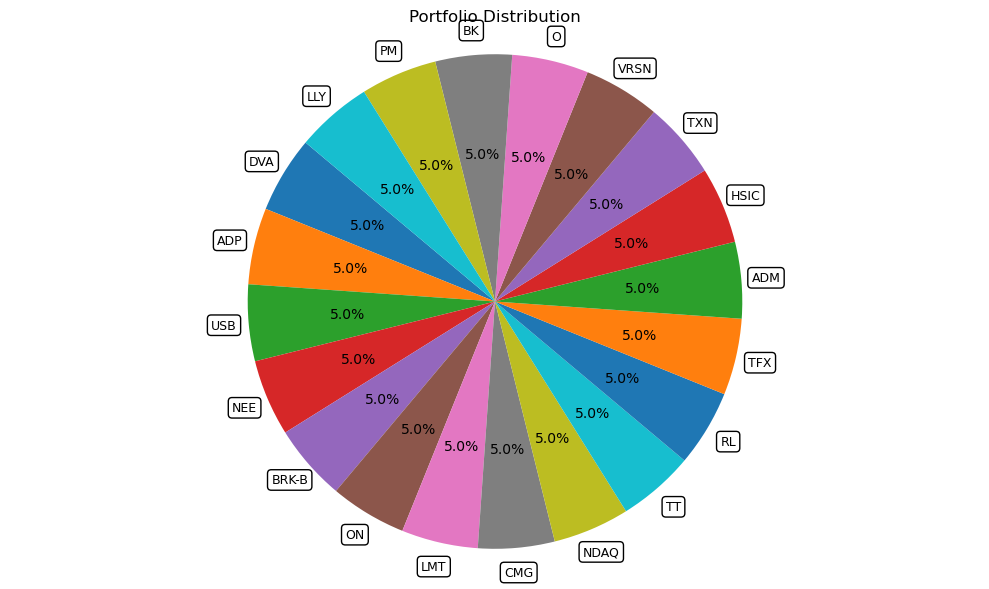

In [23]:
# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 20, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Obtain a summary of the portfolio 
random_portfolio.summarize_portfolio()

# Visualize portfolio distribution 
random_portfolio.visualize_portfolio_distribution(pname="Portfolio Distribution")


#### Optimizing the Portfolio 


--- Portfolio Summary After Optimization ---
Portfolio Summary:
Tickers: ['DVA', 'ADP', 'USB', 'NEE', 'BRK-B', 'ON', 'LMT', 'CMG', 'NDAQ', 'TT', 'RL', 'TFX', 'ADM', 'HSIC', 'TXN', 'VRSN', 'O', 'BK', 'PM', 'LLY']
Weights: {'DVA': 0.010487237644759222, 'ADP': 0.0, 'USB': 0.07820515390982065, 'NEE': 6.371974752309925e-16, 'BRK-B': 0.08578964508623554, 'ON': 1.870028518971209e-16, 'LMT': 0.05204328806538313, 'CMG': 0.1698352979935431, 'NDAQ': 0.09238002181191877, 'TT': 1.5567449130997335e-16, 'RL': 0.00491063201021504, 'TFX': 2.874999229570546e-17, 'ADM': 0.035307290820407386, 'HSIC': 3.1799310905820943e-16, 'TXN': 1.1229502365873311e-17, 'VRSN': 0.1437864176508253, 'O': 7.875712343570485e-17, 'BK': 4.87797803994279e-16, 'PM': 0.2518015274701552, 'LLY': 0.07545348753673482}
Portfolio Expected Return: 0.005683754462071522
Portfolio Volatility: 0.010294971607621923
Portfolio Diversification Ratio: 2.8860097685521096
Portfolio Sharpe Ratio: 0.5520903484438492


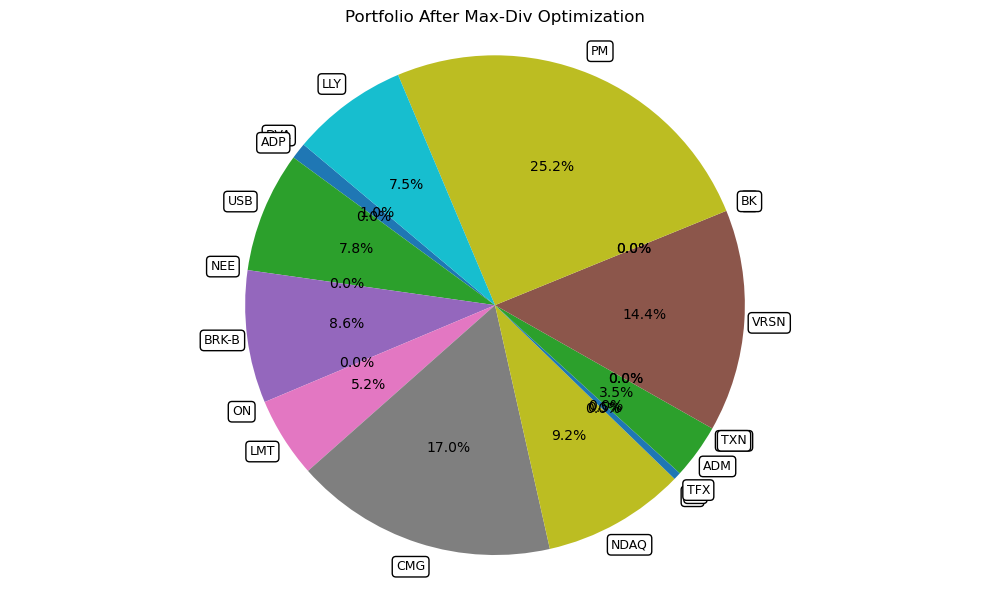

In [24]:
# Optimize portfolio weights 
random_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the portfolio after optimization
print("\n--- Portfolio Summary After Optimization ---")
random_portfolio.summarize_portfolio()

# Visualize the portfolio distribution after optimization
random_portfolio.visualize_portfolio_distribution(pname="Portfolio After Max-Div Optimization")

#### Extracting Portfolio Embeddings

In [26]:
# Define Optim method for both portfolios 
optim_method = "max_div"

# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 15, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Optimize portfolio weights 
random_portfolio.optimize_weights(method=optim_method, update_weights=True)

# Generate embeddings for the stock data (full universe of data)
stock_embeddings = get_vae_embeddings(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Extract embeddings from Portfolio  
random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                               if ticker in stock_embeddings.keys()}

# Check that number of extracted embeddings == number of portfolio tickers
assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)

# Apply the diversify function to the random portfolio
updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
    portfolio = random_portfolio,
    portfolio_embeddings = random_portfolio_embeddings,
    all_returns = all_returns,
    all_stock_embeddings = stock_embeddings,
    num_iter=200, # number of iterations for the optimization algorithm
    top_N=5, # num top most dissimilar assets to consider for swapping
    optim_algorithm=optim_method,
    distance_type="euclidean"
)

# Print the final diversification ratio and the swap log
print("\nFinal Diversification Ratio:", updated_portfolio.diversification_ratio)
print("Diversification History:", diversification_history)
print("Swap Log (Removed -> Added):", swap_log)


Initial Diversification Ratio: 2.7264586567578992


Diversification Iterations:  10%|█         | 20/200 [00:00<00:01, 98.30it/s]

Accepted Swap: TDY -> PANW
New Diversification Ratio: 3.25892444778868


Diversification Iterations: 100%|██████████| 200/200 [00:01<00:00, 100.17it/s]


Final Diversification Ratio: 3.25892444778868
Diversification History: [2.7264586567578992, 3.25892444778868]
Swap Log (Removed -> Added): {'TDY': 'PANW'}


In [27]:
print("\n--- Original Portfolio ---")
# Summarize the original random portfolio
random_portfolio.summarize_portfolio()

print("\n--- Updated Portfolio ---")

# Optimize the updated portfolio weights with max_div 
updated_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the updated portfolio
updated_portfolio.summarize_portfolio()


--- Original Portfolio ---
Portfolio Summary:
Tickers: ['TER', 'DVA', 'LIN', 'TDY', 'BALL', 'AEE', 'ULTA', 'EVRG', 'ABT', 'GIS', 'MCD', 'CBOE', 'ZM', 'WYNN', 'MOH']
Weights: {'TER': 0.10064298654965217, 'DVA': 1.9162063995584172e-16, 'LIN': 0.0, 'TDY': 0.019709461113504887, 'BALL': 3.549738332589472e-17, 'AEE': 0.09425088008930137, 'ULTA': 0.051007513639791106, 'EVRG': 0.16107662285875898, 'ABT': 0.0644196579413689, 'GIS': 0.11501099389507392, 'MCD': 9.203797973121542e-17, 'CBOE': 0.14068206665325403, 'ZM': 0.07580989466074288, 'WYNN': 0.10689480365872307, 'MOH': 0.0704951189398288}
Portfolio Expected Return: 0.002985157706788034
Portfolio Volatility: 0.013523543081679492
Portfolio Diversification Ratio: 2.726458462490201
Portfolio Sharpe Ratio: 0.2207378413155694

--- Updated Portfolio ---
Portfolio Summary:
Tickers: ['TER', 'DVA', 'LIN', 'BALL', 'AEE', 'ULTA', 'EVRG', 'ABT', 'GIS', 'MCD', 'CBOE', 'ZM', 'WYNN', 'MOH', 'PANW']
Weights: {'TER': 0.03587685546719502, 'DVA': 4.54399973283

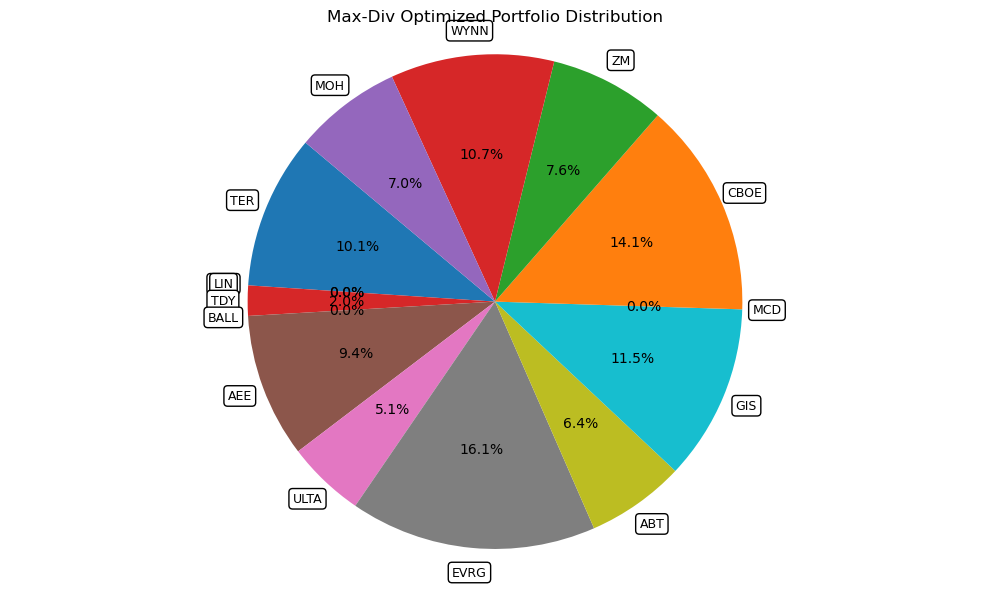

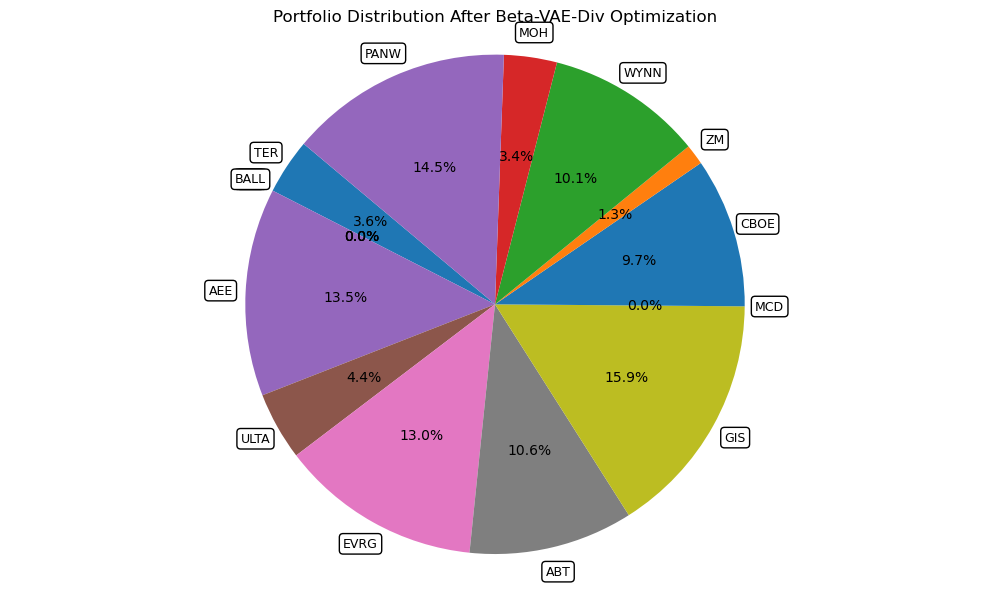

In [28]:
random_portfolio.visualize_portfolio_distribution(pname="Max-Div Optimized Portfolio Distribution")
updated_portfolio.visualize_portfolio_distribution(pname="Portfolio Distribution After Beta-VAE-Div Optimization")

### Repeat with the PCA Embeddings

In [29]:
# Subset random_porfolio embeddings from the pca_stock_embeddings
random_portfolio_embeddings_pca = {ticker: pca_stock_embeddings[ticker] for ticker in random_portfolio.tickers
                               if ticker in pca_stock_embeddings.keys()}

# Apply the diversify function to the random portfolio
updated_portfolio_pca, diversification_history_pca, swap_log = diversify_betavae_portfolio(
    portfolio = random_portfolio,
    portfolio_embeddings = random_portfolio_embeddings_pca, # replaced with pca_stock_embeddings
    all_returns = all_returns,
    all_stock_embeddings = pca_stock_embeddings, # replaced with pca_stock_embeddings universe
    num_iter=200, # number of iterations for the optimization algorithm
    top_N=5, # num top most dissimilar assets to consider for swapping
    optim_algorithm=optim_method,
    distance_type="euclidean"
)

# Print the final diversification ratio and the swap log
print("\nFinal Diversification Ratio:", updated_portfolio_pca.diversification_ratio)
print("Diversification History:", diversification_history_pca)
print("Swap Log (Removed -> Added):", swap_log)

Initial Diversification Ratio: 2.7264586567578992


Diversification Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Diversification Iterations:   4%|▎         | 7/200 [00:00<00:03, 63.15it/s]

Accepted Swap: AEE -> BKNG
New Diversification Ratio: 2.761725411383705
Accepted Swap: DVA -> FICO
New Diversification Ratio: 2.838639989942772
Accepted Swap: EVRG -> COIN
New Diversification Ratio: 3.0112266488583215
Accepted Swap: MCD -> NVR
New Diversification Ratio: 3.01122695455291
Accepted Swap: MOH -> MELI
New Diversification Ratio: 3.0951536987677066
Accepted Swap: BALL -> PLTR
New Diversification Ratio: 3.165294775300187


Diversification Iterations: 100%|██████████| 200/200 [00:02<00:00, 72.61it/s]


Final Diversification Ratio: 3.165294775300187
Diversification History: [2.7264586567578992, 2.761725411383705, 2.838639989942772, 3.0112266488583215, 3.01122695455291, 3.0951536987677066, 3.165294775300187]
Swap Log (Removed -> Added): {'AEE': 'BKNG', 'DVA': 'FICO', 'EVRG': 'COIN', 'MCD': 'NVR', 'MOH': 'MELI', 'BALL': 'PLTR'}


In [30]:
print("\n--- Original Portfolio ---")
# Summarize the original random portfolio
random_portfolio.summarize_portfolio()

print("\n--- Updated Portfolio ---")

# Optimize the updated portfolio weights with max_div 
updated_portfolio_pca.optimize_weights(method="max_div", update_weights=True)

# Summarize the updated portfolio
updated_portfolio_pca.summarize_portfolio()


--- Original Portfolio ---
Portfolio Summary:
Tickers: ['TER', 'DVA', 'LIN', 'TDY', 'BALL', 'AEE', 'ULTA', 'EVRG', 'ABT', 'GIS', 'MCD', 'CBOE', 'ZM', 'WYNN', 'MOH']
Weights: {'TER': 0.10064298654965217, 'DVA': 1.9162063995584172e-16, 'LIN': 0.0, 'TDY': 0.019709461113504887, 'BALL': 3.549738332589472e-17, 'AEE': 0.09425088008930137, 'ULTA': 0.051007513639791106, 'EVRG': 0.16107662285875898, 'ABT': 0.0644196579413689, 'GIS': 0.11501099389507392, 'MCD': 9.203797973121542e-17, 'CBOE': 0.14068206665325403, 'ZM': 0.07580989466074288, 'WYNN': 0.10689480365872307, 'MOH': 0.0704951189398288}
Portfolio Expected Return: 0.002985157706788034
Portfolio Volatility: 0.013523543081679492
Portfolio Diversification Ratio: 2.726458462490201
Portfolio Sharpe Ratio: 0.2207378413155694

--- Updated Portfolio ---
Portfolio Summary:
Tickers: ['TER', 'LIN', 'TDY', 'ULTA', 'ABT', 'GIS', 'CBOE', 'ZM', 'WYNN', 'BKNG', 'FICO', 'COIN', 'NVR', 'MELI', 'PLTR']
Weights: {'TER': 4.698717088887672e-16, 'LIN': 4.4898111

### Repeat with PCA_90 Embeddings

In [31]:
# pca_stock_embeddings_tuned = get_pca_embeddings(stock_data, scaler, pca_encoder_tuned,ticker_col="Ticker")

# Subset random_porfolio embeddings from the pca_stock_embeddings
random_portfolio_embeddings_pca90 = {ticker: pca_stock_embeddings_tuned[ticker] for ticker in random_portfolio.tickers
                               if ticker in pca_stock_embeddings_tuned.keys()}

# Apply the diversify function to the random portfolio
updated_portfolio_pca90, diversification_history_pca90, swap_log = diversify_betavae_portfolio(
    portfolio = random_portfolio,
    portfolio_embeddings = random_portfolio_embeddings_pca90, # replaced with pca_stock_embeddings
    all_returns = all_returns,
    all_stock_embeddings = pca_stock_embeddings_tuned, # replaced with pca_stock_embeddings universe
    num_iter=200, # number of iterations for the optimization algorithm
    top_N=5, # num top most dissimilar assets to consider for swapping
    optim_algorithm=optim_method,
    distance_type="euclidean"
)

# Print the final diversification ratio and the swap log
print("\nFinal Diversification Ratio:", updated_portfolio_pca90.diversification_ratio)
print("Diversification History:", diversification_history_pca90)
print("Swap Log (Removed -> Added):", swap_log)

Initial Diversification Ratio: 2.7264586567578992


Diversification Iterations:   4%|▍         | 9/200 [00:00<00:02, 79.35it/s]

Accepted Swap: AEE -> AAPL
New Diversification Ratio: 2.9487561528645325
Accepted Swap: CBOE -> BKNG
New Diversification Ratio: 3.0271107669559965


Diversification Iterations:  22%|██▎       | 45/200 [00:00<00:01, 83.50it/s]

Accepted Swap: EVRG -> EG
New Diversification Ratio: 3.040179654610707


Diversification Iterations: 100%|██████████| 200/200 [00:02<00:00, 80.65it/s]


Final Diversification Ratio: 3.040179654610707
Diversification History: [2.7264586567578992, 2.9487561528645325, 3.0271107669559965, 3.040179654610707]
Swap Log (Removed -> Added): {'AEE': 'AAPL', 'CBOE': 'BKNG', 'EVRG': 'EG'}


In [32]:
print("\n--- Original Portfolio ---")
# Summarize the original random portfolio
random_portfolio.summarize_portfolio()

print("\n--- Updated Portfolio ---")

# Optimize the updated portfolio weights with max_div 
updated_portfolio_pca90.optimize_weights(method="max_div", update_weights=True)

# Summarize the updated portfolio
updated_portfolio_pca90.summarize_portfolio()


--- Original Portfolio ---
Portfolio Summary:
Tickers: ['TER', 'DVA', 'LIN', 'TDY', 'BALL', 'AEE', 'ULTA', 'EVRG', 'ABT', 'GIS', 'MCD', 'CBOE', 'ZM', 'WYNN', 'MOH']
Weights: {'TER': 0.10064298654965217, 'DVA': 1.9162063995584172e-16, 'LIN': 0.0, 'TDY': 0.019709461113504887, 'BALL': 3.549738332589472e-17, 'AEE': 0.09425088008930137, 'ULTA': 0.051007513639791106, 'EVRG': 0.16107662285875898, 'ABT': 0.0644196579413689, 'GIS': 0.11501099389507392, 'MCD': 9.203797973121542e-17, 'CBOE': 0.14068206665325403, 'ZM': 0.07580989466074288, 'WYNN': 0.10689480365872307, 'MOH': 0.0704951189398288}
Portfolio Expected Return: 0.002985157706788034
Portfolio Volatility: 0.013523543081679492
Portfolio Diversification Ratio: 2.726458462490201
Portfolio Sharpe Ratio: 0.2207378413155694

--- Updated Portfolio ---
Portfolio Summary:
Tickers: ['TER', 'DVA', 'LIN', 'TDY', 'BALL', 'ULTA', 'ABT', 'GIS', 'MCD', 'ZM', 'WYNN', 'MOH', 'AAPL', 'BKNG', 'EG']
Weights: {'TER': 1.1009096514227704e-15, 'DVA': 0.0184770360

## Implementing the Full Experiment 

In [33]:
# # Initialize storage for portfolio results
# portfolio_results = []
# portfolio_tickers = {}

# # Define number of iterations for diversification process
# num_portfolios = 15
# num_initial_tickers = 15
# optim_method = "max_div"

# for i in tqdm(range(1, num_portfolios + 1), desc="Beta-VAE Portfolio Diversification..."):
#     # Step 1: Generate random portfolio
#     random_tickers = np.random.choice(list(all_returns.keys()), num_initial_tickers, replace=False)
#     random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}
#     random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")
    
#     # Optimize initial portfolio
#     random_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
#     # Record initial DR and SR
#     initial_dr = random_portfolio.diversification_ratio
#     initial_sr = random_portfolio.sharpe_ratio
    
#     # Step 2: Generate embeddings
#     random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
#                                    if ticker in stock_embeddings.keys()}
#     assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)
    
#     # Step 3: Apply diversification function
#     updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
#         portfolio=random_portfolio,
#         portfolio_embeddings=random_portfolio_embeddings,
#         all_returns=all_returns,
#         all_stock_embeddings=stock_embeddings,
#         num_iter=200,
#         top_N=5,
#         optim_algorithm=optim_method,
#         distance_type="euclidean", 
#         verbose=False
#     )
    
#     # Optimize the updated portfolio after swaps
#     updated_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
#     # Record updated DR and SR
#     final_dr = updated_portfolio.diversification_ratio
#     final_sr = updated_portfolio.sharpe_ratio
    
#     # Store tickers for the updated portfolio
#     portfolio_tickers[f"Portfolio_{i}"] = updated_portfolio.tickers
    
#     # Save results for the dataframe
#     portfolio_results.append({
#         "Portfolio": f"Portfolio_{i}",
#         "Initial_DR": initial_dr,
#         "Final_DR": final_dr,
#         "DR_Improvement": round(((final_dr - initial_dr)/initial_dr) * 100, 3), # pct improvement
#         "Initial_SR": initial_sr,
#         "Final_SR": final_sr, 
#         "SR_Improvement": round(((final_sr - initial_sr)/initial_sr) * 100, 3), # pct improvement
#         "Tickers": updated_portfolio.tickers
#     })

# # Convert results to a DataFrame
# portfolio_results_df = pd.DataFrame(portfolio_results)

# # Sort by Final_DR
# portfolio_results_df = portfolio_results_df.sort_values(by="DR_Improvement", ascending=False)


In [35]:
# # Display the table
# display(portfolio_results_df)

In [36]:
# # disply sorted by final SR
# display(portfolio_results_df.sort_values(by="SR_Improvement", ascending=False))


### Full Experiment: All Methods

In [54]:
# Initialize storage for portfolio results
portfolio_results = []
portfolio_tickers = {}

# Define number of iterations for diversification process
num_portfolios = 20
num_initial_tickers = 10
optim_method = "max_div"

for i in tqdm(range(1, num_portfolios + 1), desc="Portfolio Diversification Experiments..."):
    # Step 1: Generate random portfolio
    random_tickers = np.random.choice(list(all_returns.keys()), num_initial_tickers, replace=False)
    random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}
    random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")
    
    # Optimize initial portfolio
    random_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record initial diversification ratio (DR) and Sharpe ratio (SR)
    initial_dr = random_portfolio.diversification_ratio
    initial_sr = random_portfolio.sharpe_ratio
    
    # Initialize results container for this portfolio
    portfolio_experiments = []
    
    # Define embedding methods and corresponding data
    methods = [
        ("Beta-VAE", stock_embeddings),
        ("PCA (Latent Dim)", pca_stock_embeddings),
        ("PCA (90% Var)", pca_stock_embeddings_tuned)
    ]
    
    for method_name, embeddings in methods:
        # Step 2: Generate portfolio-specific embeddings
        random_portfolio_embeddings = {
            ticker: embeddings[ticker] for ticker in random_portfolio.tickers if ticker in embeddings.keys()
        }
        assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)

        # Step 3: Apply diversification function
        updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
            portfolio=random_portfolio,
            portfolio_embeddings=random_portfolio_embeddings,
            all_returns=all_returns,
            all_stock_embeddings=embeddings,
            num_iter=250,
            top_N=10,
            optim_algorithm=optim_method,
            distance_type="euclidean",
            verbose=False
        )
        
        # Optimize the updated portfolio after swaps
        updated_portfolio.optimize_weights(method=optim_method, update_weights=True)
        
        # Record updated DR and SR
        final_dr = updated_portfolio.diversification_ratio
        final_sr = updated_portfolio.sharpe_ratio
        
        # Store results for this method
        portfolio_experiments.append({
            "Portfolio": f"Portfolio_{i}",
            "Method": method_name,
            "Initial_DR": initial_dr,
            "Final_DR": final_dr,
            "DR_Improvement": round(((final_dr - initial_dr) / initial_dr) * 100, 3),  # pct improvement
            "Initial_SR": initial_sr,
            "Final_SR": final_sr,
            "SR_Improvement": round(((final_sr - initial_sr) / initial_sr) * 100, 3),  # pct improvement
            "Tickers": updated_portfolio.tickers
        })
        
    # Append all results for this portfolio to the overall results
    portfolio_results.extend(portfolio_experiments)

# Convert results to a DataFrame
portfolio_results_df = pd.DataFrame(portfolio_results)

# Sort results by method and DR improvement
portfolio_results_df = portfolio_results_df.sort_values(by=["Method", "DR_Improvement"], ascending=False)

Portfolio Diversification Experiments...:   0%|          | 0/20 [00:00<?, ?it/s]

Diversification Iterations: 100%|██████████| 250/250 [00:02<00:00, 109.98it/s]


In [56]:
portfolio_results_df.sort_values(by=["DR_Improvement"], ascending=False)

,Portfolio,Method,Initial_DR,Final_DR,DR_Improvement,Initial_SR,Final_SR,SR_Improvement,Tickers
48,Portfolio_17,Beta-VAE,2.008874,3.724985,85.426,0.264460,0.557309,110.735,"[PANW, AME, D, BBY, ABT, DD, MSFT, NET, T, SLB]"
3,Portfolio_2,Beta-VAE,2.118884,3.826035,80.568,0.215653,0.517187,139.824,"[CTRA, AMCR, PANW, D, MSFT, T, VRSN, GEHC, HOL..."
6,Portfolio_3,Beta-VAE,2.234546,3.663383,63.943,0.378467,0.457902,20.988,"[META, KDP, EQR, D, PANW, CTRA, BBY, HOLX, MOH..."
21,Portfolio_8,Beta-VAE,2.374113,3.642329,53.419,0.247112,0.646096,161.459,"[CBOE, AAPL, D, BSX, PANW, CRL, DLR, GEHC, AME..."
36,Portfolio_13,Beta-VAE,2.483185,3.702363,49.097,0.334537,0.390646,16.772,"[ADM, IP, CTRA, PANW, KDP, D, AMCR, HOLX, VRSN..."
30,Portfolio_11,Beta-VAE,2.058986,2.938083,42.696,0.424572,0.372099,-12.359,"[AMGN, EQR, AMCR, MNST, SLB, D, NCLH, MSFT, AM..."
9,Portfolio_4,Beta-VAE,2.369860,3.281240,38.457,0.354795,0.426813,20.299,"[BMY, DOCU, AIG, MNST, PANW, D, T, DD, CTRA, NKE]"
34,Portfolio_12,PCA (Latent Dim),2.159172,2.927961,35.606,0.280038,0.418356,49.393,"[BKNG, AZO, PLTR, SMCI, ORLY, MRNA, REG, TPL, ..."
50,Portfolio_17,PCA (90% Var),2.008874,2.716757,35.238,0.264460,0.327216,23.730,"[KHC, FNV, CEG, AAPL, BKNG, ODFL, EG, VEEV, SY..."
51,Portfolio_18,Beta-VAE,2.329768,3.138354,34.707,0.068625,0.443999,546.994,"[FTV, CNC, UNH, DLTR, TMO, NFLX, HOLX, BSX, T,..."


### Per_Method

In [58]:
portfolio_results_df.sort_values(by=["Method", "DR_Improvement"], ascending=False)

,Portfolio,Method,Initial_DR,Final_DR,DR_Improvement,Initial_SR,Final_SR,SR_Improvement,Tickers
34,Portfolio_12,PCA (Latent Dim),2.159172,2.927961,35.606,0.280038,0.418356,49.393,"[BKNG, AZO, PLTR, SMCI, ORLY, MRNA, REG, TPL, ..."
55,Portfolio_19,PCA (Latent Dim),2.017945,2.705619,34.078,0.201849,0.338435,67.668,"[LUV, EL, RCL, TPL, MELI, TDG, AZO, NVR, COIN,..."
52,Portfolio_18,PCA (Latent Dim),2.329768,3.052263,31.011,0.068625,0.485189,607.017,"[BKNG, TPL, AZO, MELI, ORLY, OXY, TSLA, MO, SH..."
25,Portfolio_9,PCA (Latent Dim),2.271713,2.890716,27.248,0.517212,0.654653,26.574,"[HES, T, ISRG, MELI, BKNG, ENPH, PLTR, AZO, CL..."
7,Portfolio_3,PCA (Latent Dim),2.234546,2.786754,24.712,0.378467,0.293393,-22.479,"[MELI, SYY, META, XOM, RVTY, TSLA, COIN, SMCI,..."
4,Portfolio_2,PCA (Latent Dim),2.118884,2.586022,22.046,0.215653,0.297161,37.796,"[LW, ORLY, GPN, BKNG, COIN, MTD, FSLR, MELI, E..."
28,Portfolio_10,PCA (Latent Dim),2.284548,2.710448,18.643,0.352557,0.460749,30.688,"[GOOGL, AEE, ORLY, MELI, PLTR, CL, MTD, NCLH, ..."
49,Portfolio_17,PCA (Latent Dim),2.008874,2.355091,17.234,0.264460,0.375403,41.951,"[ISRG, CCI, FMC, MMC, AZO, ORLY, BKNG, FICO, E..."
1,Portfolio_1,PCA (Latent Dim),2.469439,2.857665,15.721,0.122782,0.259996,111.754,"[MCK, ARE, EPAM, ULTA, MDLZ, BKNG, ENPH, SMCI,..."
31,Portfolio_11,PCA (Latent Dim),2.058986,2.376267,15.410,0.424572,0.331607,-21.896,"[COST, KVUE, ALL, CEG, TPL, AMGN, TSLA, MTD, B..."


### Tables for the Paper

In [60]:
# Compute the average initial and final DR, and average DR improvement for each method
avg_results = portfolio_results_df.groupby('Method').agg(
    Average_Initial_DR=('Initial_DR', 'mean'),
    Average_Final_DR=('Final_DR', 'mean'),
    Average_DR_Improvement=('DR_Improvement', 'mean')
).reset_index()

# Sort by Average_DR_Improvement descending for clarity
avg_results = avg_results.sort_values(by="Average_DR_Improvement", ascending=False)

print(avg_results)


             Method  Average_Initial_DR  Average_Final_DR  \
0          Beta-VAE            2.335059          3.125257   
2  PCA (Latent Dim)            2.335059          2.726827   
1     PCA (90% Var)            2.335059          2.635625   

   Average_DR_Improvement  
0                34.97845  
2                17.18670  
1                13.37660  


In [61]:
# Filter for Beta-VAE and sort by DR Improvement
beta_vae_top = portfolio_results_df[portfolio_results_df['Method'] == 'Beta-VAE'] \
    .sort_values(by='DR_Improvement', ascending=False).head(3)

print(beta_vae_top[['Portfolio', 'Initial_DR', 'Final_DR', 'DR_Improvement', 'Initial_SR', 'Final_SR', 'SR_Improvement']])

       Portfolio  Initial_DR  Final_DR  DR_Improvement  Initial_SR  Final_SR  \
48  Portfolio_17    2.008874  3.724985          85.426    0.264460  0.557309   
3    Portfolio_2    2.118884  3.826035          80.568    0.215653  0.517187   
6    Portfolio_3    2.234546  3.663383          63.943    0.378467  0.457902   

    SR_Improvement  
48         110.735  
3          139.824  
6           20.988  


In [62]:
# Filter for PCA (Latent Dim) and sort by DR Improvement
pca_latent_top = portfolio_results_df[portfolio_results_df['Method'] == 'PCA (Latent Dim)'] \
    .sort_values(by='DR_Improvement', ascending=False).head(3)

print(pca_latent_top[['Portfolio', 'Initial_DR', 'Final_DR', 'DR_Improvement', 'Initial_SR', 'Final_SR', 'SR_Improvement']])


       Portfolio  Initial_DR  Final_DR  DR_Improvement  Initial_SR  Final_SR  \
34  Portfolio_12    2.159172  2.927961          35.606    0.280038  0.418356   
55  Portfolio_19    2.017945  2.705619          34.078    0.201849  0.338435   
52  Portfolio_18    2.329768  3.052263          31.011    0.068625  0.485189   

    SR_Improvement  
34          49.393  
55          67.668  
52         607.017  


In [63]:
# Filter for PCA (90% Var) and sort by DR Improvement
pca_90var_top = portfolio_results_df[portfolio_results_df['Method'] == 'PCA (90% Var)'] \
    .sort_values(by='DR_Improvement', ascending=False).head(3)

print(pca_90var_top[['Portfolio', 'Initial_DR', 'Final_DR', 'DR_Improvement', 'Initial_SR', 'Final_SR', 'SR_Improvement']])

       Portfolio  Initial_DR  Final_DR  DR_Improvement  Initial_SR  Final_SR  \
50  Portfolio_17    2.008874  2.716757          35.238    0.264460  0.327216   
56  Portfolio_19    2.017945  2.500978          23.937    0.201849  0.281065   
5    Portfolio_2    2.118884  2.611953          23.270    0.215653  0.257880   

    SR_Improvement  
50          23.730  
56          39.245  
5           19.581  
